# Machine Learning for Particle People
Flip Tanedo; adapted from Ben Nachman  
(All errors are due to Flip)  
19 January 2019  

This is the *Hello World* of neural networks. The code is lightly adapted from starter code from **Dr. [Ben Nachman](https://bnachman.web.cern.ch/bnachman/)** (LBNL) from his visit to UCR as part of an APS Gordon and Betty Moore Foundation Fundamental Physics Innovation Award in January 2019. 

## Pre-Requisites

This notebook assumes a background in particle physics but no formal background in machine learning. It probably doesn't require much particle physics, either, but the comments will be geared towards a physicist who is curious about machine learning. You should know something about the big picture of machine learning; for this you can find several excellent explainer videos on YouTube. 

You should be comfortable with Jupyter notebooks. I'm no expert by any stretch of the imagination, everything I know is in my [Physics 177: Computational Physics](https://github.com/Physics177-2017) course.

## Getting Set Up

This notebook assumes that you have Python 3.6 up and running on your system. I'm using macOS, so I installed using Homebrew. **Note**: at the time of this writing, TensorFlow is *not compatible* with Python 3.7. You can [install 3.6 through Homebrew](https://stackoverflow.com/a/51125014). 

Use `pip` (that is: `pip3`) to install the standard scientific Python libraries, e.g. `matplotlib`. For this tutorial, we'll use `keras`, `tensorflow`, and `sklearn`, which you should also install with `pip`. 

Once you have that, this notebook should run with no problems. 

## Importing Libraries

* `numpy` is a common library in scientific Python. We store our data in `numpy` arrays. 
* `keras` is a convenient interface for running machine learning software libraries. 
* `tensorflow` is a standard machine learning library
* `sklearn` (scikit-learn) is another machine learning library built on `scipy`. We'll use it for making a **[ROC curve](http://arogozhnikov.github.io/2015/10/05/roc-curve.html)**.

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Using TensorFlow backend.


## Generate training data

We'll use `numpy` to generate training data. Each data point is a single number. This could be something like the invariant mass of a dilepton pair. 

Each data point comes from either  
(a) a signal distribution, say a gaussian centered at 0  
(b) a background distribution, say a gaussian centered at 1.

We use the `random.normal` function from `numpy` to generate arrays of 1000 signal and background events. 

`np.random.normal(0,1,1000)` generates a 1000-element array drawn from a gaussian distribution centered at 0 with standard deviation 1. [Documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html).

In [3]:
signal = np.random.normal(0,1,1000)
background = np.random.normal(1,1,1000)

We can plot these as histograms with `matplotlib`. The `alpha` value sets transparency ([docs](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html)) and `rwidth` is the relative width of the bar relative to the bin width ([docs](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html)).

(array([  3.,   2.,   3.,  10.,  14.,  20.,  29.,  55.,  65.,  85.,  99.,
         95.,  91.,  97., 102.,  72.,  52.,  30.,  39.,  13.,  12.,   7.,
          1.,   1.,   1.,   2.]),
 array([-2.27416841, -2.00967787, -1.74518734, -1.4806968 , -1.21620627,
        -0.95171574, -0.6872252 , -0.42273467, -0.15824413,  0.1062464 ,
         0.37073693,  0.63522747,  0.899718  ,  1.16420854,  1.42869907,
         1.6931896 ,  1.95768014,  2.22217067,  2.48666121,  2.75115174,
         3.01564227,  3.28013281,  3.54462334,  3.80911388,  4.07360441,
         4.33809495,  4.60258548]),
 <a list of 26 Patch objects>)

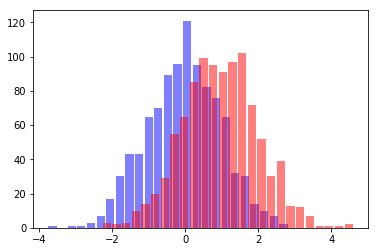

In [5]:
plt.hist(signal, bins='auto', color='blue', alpha=0.5, rwidth=0.85)
plt.hist(background, bins='auto', color='red', alpha=0.5, rwidth=0.85)

## Creating and Training a Neural Network

Here's where we're "doing machine learning."

### Setting up training data

Given a particular datapoint, we would like to determine whether it is more likely to be signal or background. We'll build a neural net to do this, but we need to train it first. Our training data is already separated into signal and background. However, we need to feed this into our machine in a particular way: 

(a) an array of data points $X[i]$  
(b) an array of booleans $Y[i]$ that identifies whether $X[i]$ is signal (1) or background (0).

In [6]:
signal_labels = np.ones(len(signal))
background_labels = np.zeros(len(background))

X = np.concatenate((signal, background))
Y = np.concatenate((signal_labels, background_labels))

### Creating our first neural network

Now we'll create a neural network. We initialize the neural network by calling `Sequential()` from `keras.models`. That creates a neural network ([docs](https://keras.io/getting-started/sequential-model-guide/)). The network has no layers yet; we add those by hand.

Each `model.add` call adds a layer to the neural net. We add densely-connected layers with `Dense` ([Other kinds of layers](https://forums.fast.ai/t/dense-vs-convolutional-vs-fully-connected-layers/191/4), [docs](https://keras.io/layers/core/)). The first layer we create has 12 nodes and we tell it that the dimension of the input is 1 (each input datum is just a number). For each layer we must specify an `activation` function ([docs](https://keras.io/activations/)). `relu` is a standard choice ([discussion](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning)). 

The last layer we add has only one node and is activated by a `sigmoid`, which only outputs a number between 0 and 1. This is what we want as an output from the machine: is a data point more signal-like or background-like?


**Remark**: The activation function is the secret to the magic of machine learning. These functions allow deep neural networks to encode nonlinear functions. Otherwise, any number of layers is simply matrix multiplication.

In [19]:
model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The next thing we have to specify is the **loss function**. Here are some of [Keras loss functions](https://keras.io/losses/). The loss function is where you tell the machine *what* it should be learning from the training data.  We'll use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error). 

What this does: in a given round machine makes predictions on the $N$ pieces of training data. Each datum has a predicted value: 1 or 0. This is compared to the true value (which is also either 1 or 0). The mean of the squared error is the loss---it is a score for how good the machine is. 

Training (fitting) the machine (model) involves asking the machine to adjust its parameters to reduce the loss. In order to do this, moves in the space of parameters. We'll use a standard choice, **stochastic gradient descent**. Here's the main idea: we would like to calculate the gradient of the loss function over parameter space and adjust the parameters towards decreasing loss. We can do this numerically, but for a large number of parameters it is computationally costly. Instead, we can do this *stochastically* by calculating the gradient for just a small, randomly chosen set of inputs.  [Optimizers in Keras](https://en.wikipedia.org/wiki/Mean_squared_error). 

The other option in our model compilation is to specify that we'd like to output the accuracy.

In [20]:
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['accuracy'])

### Training our neural network

Now the neural network is ready for our training data. Let's feed it with the `fit` function. Some vocabulary:

**Batch size**: the number of training data points to go through before updating the parameters.  
**Epoch**: one pass through all of the training data, which includes many batches and many parameter updates.  

We will choose to look at 10 data points at a time between updating parameters: `batch_size=10`. We will go over the whole data set this way three times: `epochs=3`. 

[Batch vs Epoch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/).

In [21]:
model.fit(X, Y, epochs=3, batch_size=10)

Epoch 1/3
2000/2000 [==============================] - 0s 195us/step - loss: 0.2423 - acc: 0.6150
Epoch 2/3
2000/2000 [==============================] - 0s 99us/step - loss: 0.2257 - acc: 0.6670
Epoch 3/3
2000/2000 [==============================] - 0s 88us/step - loss: 0.2177 - acc: 0.6780


**Not included**: we are not including *validation*, which is a check that the training procedure did not [*over-fit*](https://elitedatascience.com/overfitting-in-machine-learning). 


## Testing our Neural Network, ROC curves

Making predictions from the machine is simple. Just use the `predict(X)` method on an array of data. Here's a silly example: let's make predictions on the training data. (This is, of course, a silly thing to ask.)

In [34]:
predictions = model.predict(X)
print(X[1:5])
print(predictions[1:5])

[-0.60060602  2.21210266  0.81947856 -0.27386162]
[[0.57057405]
 [0.25970876]
 [0.41226888]
 [0.5548525 ]]


Let's do something a little more interesting and output a [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Some useful vocabulary:

**FPR**: [false positive rate](https://en.wikipedia.org/wiki/False_positive_rate), rate at which the machine incorrectly calls something signal when it is in fact data

***TPR**: [true positive rate](https://stats.stackexchange.com/a/61838) or sensitivity, rate at which the machine correctly calls something signal.

Let's take our silly example again: we inputted our training data `X` into our machine and saved the outputs into `predictions`. Now we use the `roc_curve` function from `sklearn` to output the false positive and true positive rates. A ROC curve is simply a plot of these. 

In [36]:
fpr, tpr, _ = roc_curve(Y, predictions)

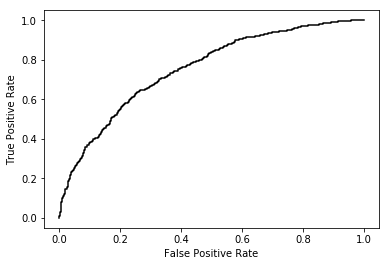

In [37]:
plt.plot(fpr, tpr, color='black')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.show()

## References

* The [first chapter of Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html) is a good parallel discussion of the toy example above, even though the data is more complicated (handwritten numbers).